### Field-Bounds
#### The Following script clips an orthomap to an area of interest. 
#### The clipped AOI is then segmented and the boundaries of the segmented areas are written to a shapefiles to extract zonal statistics on the input AOI geoTiff file. 

### Load Libraries

%matplotlib inline

import ee
import os
import rasterio
import affine
import matplotlib.pyplot as plt
import cv2
import numpy as np
import fiona
import sys
import itertools as it
import matplotlib as mplt
import shapely

from osgeo import gdal

from skimage.filters import sobel
from skimage import segmentation

from skimage import feature
from skimage import data
from skimage import filters
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage.filters.rank import entropy
from skimage.morphology import disk

from skimage import (transform, exposure, segmentation,
                     filters, feature, morphology)

from skimage.color import label2rgb
from scipy import ndimage as ndi

from PIL import Image

from rasterio import plot
from rasterio.plot import show,show_hist
from rasterio.features import shapes as polygonize

from matplotlib import pyplot
from rasterio.plot import show,reshape_as_raster, reshape_as_image
from rasterio.mask import mask as msk


import matplotlib as mpl
from descartes import PolygonPatch

### Calculate the NDVI band

In [ ]:


outfile = r'groenlo/p0_results/ndvi.tif'
#url to the bands
red = 'groenlo/red.tif'
nir = 'groenlo/nir.tif'

#open the bands (I can't believe how easy is this with rasterio!)
with rasterio.open(red) as red:
    RED = red.read()
with rasterio.open(nir) as nir:
    NIR = nir.read()

#compute the ndvi

np.seterr(divide='ignore', invalid='ignore')

ndvi = (NIR.astype(float)-RED.astype(float))/(NIR+RED)
print(ndvi.min(), ndvi.max()) 

profile = red.meta
profile.update(driver='GTiff')
profile.update(dtype=rasterio.float32)

with rasterio.open(outfile, 'w', **profile) as dst:
    dst.write(ndvi.astype(rasterio.float32))
    

### Read New NDVI Map

In [174]:
import numpy.ma as ma
with rasterio.open('groenlo/p0_results/ndvi.tif',masked=True) as src:
    ndvi = src.read()
    

### Show Image Histogram

In [ ]:
show_hist(ndvi,30)

### Mask no data values

In [134]:
import copy
ndvim = copy.copy(ndvi)

ndvim[ndvi == 0] = np.nan

### Mask NoData Values

In [ ]:
veg = rasterio.open('groenlo/p0_results/ndvi.tif',masked=True)
aff = (veg.meta)['affine']
veg_nd = veg.read(1)
veg_nd[veg_nd == 0 ] = np.nan
veg_nd[veg_nd < 0 ] = 0


### Plot the Mask Orthomap

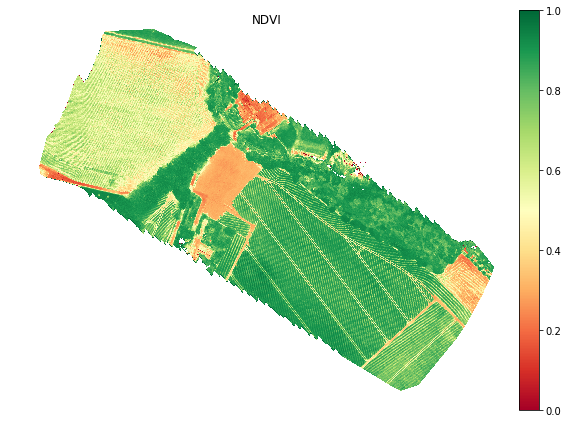

In [499]:
fig, ax = plt.subplots(figsize=(8, 8),
                          sharex=True, sharey=True)
img0 = ax.imshow(veg_nd, cmap = 'RdYlGn')
ax.set_title("NDVI")

ax.axis("off")
fig.colorbar(img0, ax=ax,fraction=0.04)
fig.tight_layout()

plt.show()

### Plot the AOI Shapefile

In [ ]:
import geopandas as gp
plots = gp.GeoDataFrame.from_file(
    'aoi.shp')
plots.head()

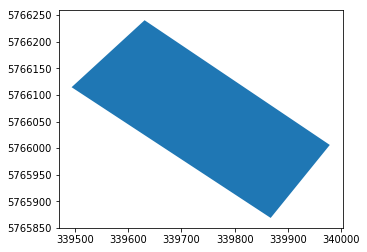

In [85]:
plots.plot()

### Verify the AOI Placement

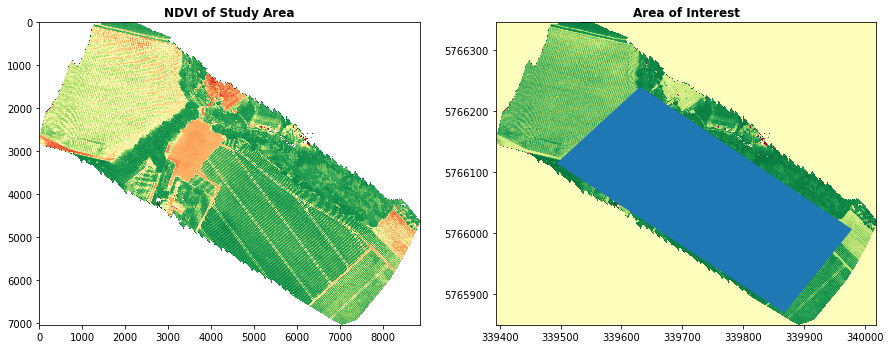

In [501]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

#im = np.array(Image.open('stinkbug.png'), dtype=np.uint8)

# Create figure and axes
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

# Display the image
show((veg_nd),ax=ax1,cmap='RdYlGn',title='NDVI of Study Area')

# Display the area of interest
show((veg,1),ax=ax2,cmap='RdYlGn',title='Area of Interest')

# Create a Rectangle patch

with fiona.open("aoi.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
patches = [PolygonPatch(feature, edgecolor="red", facecolor="none", linewidth=2) for feature in features]

#rect = patches.Rectangle((2000,1500),5500,4500,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax2.add_collection(mplt.collections.PatchCollection(patches))


#plt.savefig('groenlo/p0_results/plot.png')
#plt.show()

## Crop Image


### Clip to AOI

In [504]:

with rasterio.open("groenlo/p0_results/ndvi.tif") as src:
    out_image, out_transform = msk(src, features, crop=True)
    out_meta = src.meta.copy()
    #out_image [out_image == 0] = np.nan
    
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "affine":veg.meta['affine']
                })
out_image.astype(rasterio.uint8)

with rasterio.open("groenlo/p0_results/AoiPlots.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/Users/jesselahaye/miniconda3/envs/gee.py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


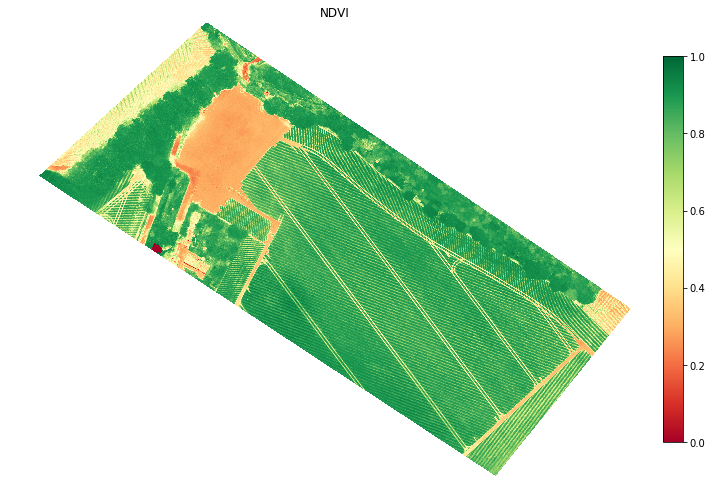

In [506]:
with rasterio.open('groenlo/p0_results/AoiPlots.tif',masked=True) as src:
    aoi= src.read(1)
    aoi[aoi == -10000] = np.nan
    aoi[aoi < 0 ] = 0

fig, ax1 = plt.subplots(figsize=(10,10),sharex=True, sharey=True)    
img0 = ax1.imshow(aoi,cmap ='RdYlGn')
ax1.set_title("NDVI")
ax1.axis('off')
fig.colorbar(img0,ax=ax1,fraction=0.03)
fig.tight_layout()

plt.show()
#plt.savefig('groenlo/p0_results/aoi.png')

### Filter AOI Image
#### Test local-mean, bilateral, and percentile filters to remove non-uniformity in plots.

In [ ]:
selem = disk(12)

with rasterio.open('groenlo/p0_results/AoiPlots.tif',masked=True) as src:
    aoi1= src.read(1)
    aoi1[aoi1 == -10000] = np.nan
    aoi1[aoi1 < 0] = 0
    aoi1[aoi1 > 1 ] = 1

percentile_result = rank.mean_percentile(aoi1, selem=selem, p0=0.05, p1=0.95)
bilateral_result = rank.mean_bilateral(aoi1, selem=selem, s0=2, s1=2)
normal_result = rank.mean(aoi1, selem=selem)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original', 'Percentile mean', 'Bilateral mean', 'Local mean']
imgs = [aoi1, percentile_result, bilateral_result, normal_result]
for n in range(0, len(imgs)):
    img = ax[n].imshow(imgs[n], cmap='RdYlGn')
    ax[n].set_title(titles[n])
    ax[n].axis('off')
    #fig.colorbar(img,ax[n])
    
plt.tight_layout()
plt.show()

### EVI (Not Used)
##### Calculate 2 Band EVI: 2.5\*\((NIR-Red)/(NIR+2.4*Red+1))

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

def evi(red,nir):
    evi = 2.5*((nir.astype(float) - red.astype(float))) / (nir.astype(float) + 2.4*red.astype(float) + 1)
    return evi

evi = evi(red,nir)

### Run Edge Detection on Local-Mean Result


In [ ]:
edges1 = sobel(percentile_result)
edges2 = sobel(normal_result)
bounds1 = edges1
bounds2 = edges2

fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,15))
#ax.axis('off')
show(bounds1,ax=ax1,cmap=plt.cm.gray,interpolation='nearest',title='Percentile Mean')
show(bounds2,ax=ax2,cmap=plt.cm.gray,interpolation='nearest',title='Local Mean')

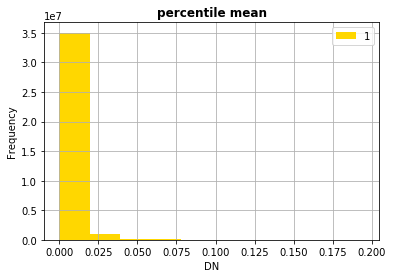

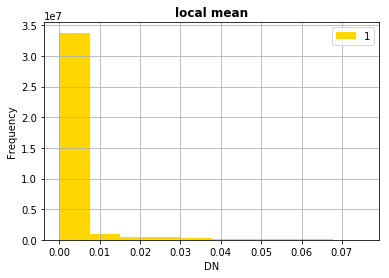

In [413]:
#fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(15,15))
show_hist(bounds1,10,title='percentile mean')
show_hist(bounds2,10,title='local mean')

### Set Clipped border to 0 values to exclude from segmentation

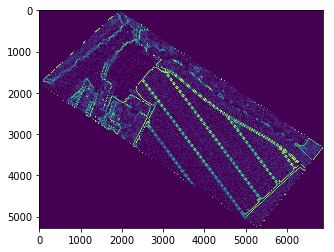

In [414]:
bounds2 = edges2
bounds2 = bounds2.astype(rasterio.float64)
bounds2[bounds2 > 0.035 ] = 0

show(bounds2)

In [ ]:
markers = np.zeros_like(bounds2)
markers[bounds2 == 0 ] = 0
markers[bounds2 < 0.015 ] = 1
markers[bounds2 > 0.015 ] = 2

#markers[percentile_result < 100] = 3
#markers[percentile_result < 50] = 3

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')
#ax.set_adjustable('box-forced')



In [ ]:
help(morphology.watershed)

### Find Field Boundaries with Segmentation Methods

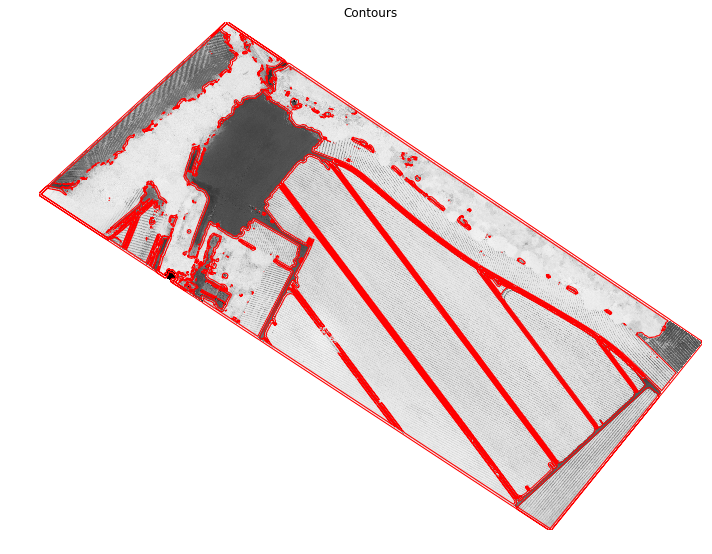

In [512]:
from skimage import morphology
from skimage.color import label2rgb
from scipy import ndimage as ndi

segmentation = morphology.watershed(bounds2,markers)

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
#ax.set_title('segmentation')
#ax.axis('off')
#ax.set_adjustable('box-forced')

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_plots, _ = ndi.label(segmentation)
plot_overlay = label2rgb(labeled_plots, image=aoi)

type(labeled_plots)

titles = 'Contours'
fig, axes = plt.subplots( figsize=(10, 10))
axes.imshow(aoi, cmap=plt.cm.gray, interpolation='nearest')
axes.contour(segmentation,[0.4] ,linewidths=1, colors='r')
axes.set_title(titles)
axes.axis('off')
    
plt.tight_layout()
#plt.savefig('groenlo/p0_results/contours.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


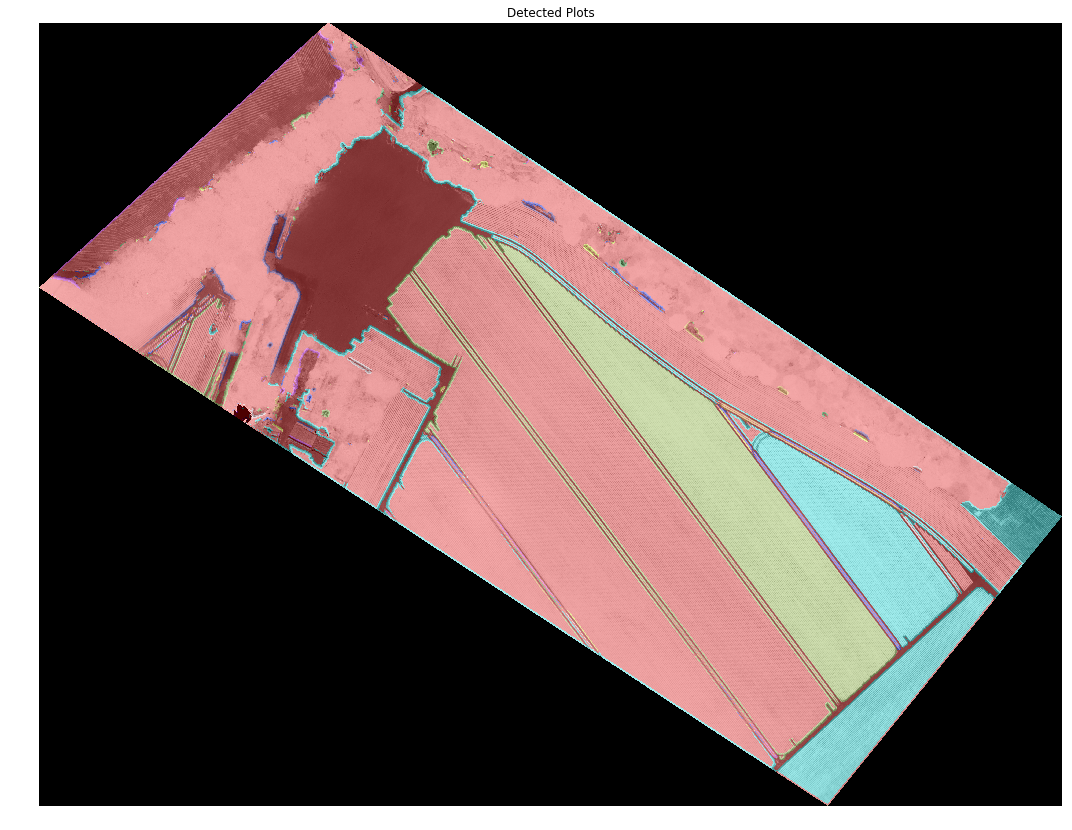

In [513]:
titles = 'Detected Plots'
fig, axes = plt.subplots(figsize=(15, 15))
axes.imshow(plot_overlay, interpolation='nearest')
axes.set_title(titles)
axes.axis('off')

plt.tight_layout()
plt.savefig('groenlo/p0_results/bounds.png')

In [467]:
borders = plt.contour(segmentation,[0.4] ,linewidths=1, colors='r',origin='image')
bounds= borders.collections

In [ ]:
len(borders.collections)
#type(segmentation)

### Write Contours to Shapefiles

In [447]:
def write_segments(fn, segments, mask, source_crs,
                   raster_meta, write_raster=True):
    '''
    Convert a numpy array of segments to polygons using
    rasterio.features.shapes and write the resultant records
    to a Shapefile.
    '''
    segments = segments.astype('int32')
    if write_raster:
        raster_meta.update(dtype=rasterio.int32,
                           count=1,
                           compress='lzw',
                           nodata=0)
        raster_fn = os.path.splitext(fn)[0] + '.tif'
        with rasterio.open(raster_fn, 'w', **raster_meta) as gtiff:
            gtiff.write(segments, 1)
            gtiff.write_mask(mask)

    shp_schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}
    with fiona.open(fn, 'w', driver='ESRI Shapefile',
                    crs=source_crs, schema=shp_schema) as shpfile:
        for shape, val, in polygonize(segments,
                                      transform=raster_meta['transform'],
                                      mask=mask):
            record = dict(geometry=shape, id=val, properties={'id': val})
            shpfile.write(record)

In [442]:
testPlot = rasterio.open('groenlo/p0_results/AoiPlots.tif')
tpMeta = testPlot.meta


In [445]:
mask= testPlot.read(1) != tpMeta['nodata']
#mask = np.logical_or(mask, band != nd)

In [446]:
crs = tpMeta['crs']

### Write Labeled Plots to Shape file

In [ ]:
pltPoly = write_segments('groenlo/p0_results/test_plot',labeled_plots,mask,crs,tpMeta,True)

In [ ]:
with rasterio.open('test_plot.tif') as src:
    testaoi = src.read(1)
    testaoi = testaoi.astype(np.float32)
    testaoi [testaoi == 0 ] = np.nan

show(testaoi)

